<a href="https://colab.research.google.com/github/Rishika70/Hack_To_Hire/blob/main/Hack_To_Hire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip install transformers

In [111]:
!pip install datasets transformers


In [ ]:
!pip install bleu

  Preparing metadata (setup.py) ... done
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5780 sha256=d05d40f5f5ec1cc422687b4c90e94bff2531d4e9b24d37b0fdfb67c1cf6b7edf
  Stored in directory: /root/.cache/pip/wheels/c6/d8/d1/009abe01b8b2c6a14c62d197b510b3cc1076014c22d712c5ce
Successfully built bleu


In [101]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import T5Tokenizer, T5Model
from transformers import GPT2Tokenizer, GPT2Model
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from transformers import BertTokenizer, DataCollatorWithPadding
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import re
import html
from collections import Counter



# Tokenization

In [ ]:
# Tokenize the data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [112]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["question"], examples["answer"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["question", "answer"])

# Preview the tokenized dataset
print(tokenized_datasets["train"][0])




Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

{'input_ids': [101, 2339, 7188, 1045, 2131, 1999, 1996, 6457, 2026, 6513, 2215, 2000, 3693, 1029, 102, 3475, 1521, 1056, 2009, 9643, 1029, 2017, 2052, 8415, 2008, 2045, 2347, 1521, 1056, 2438, 2980, 2300, 2000, 2175, 2105, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

#**Data Pre-Processing**

In [ ]:

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the 'question' and 'answer' columns
dataset = dataset.map(lambda x: {'question': preprocess_text(x['question']),
                                 'answer': preprocess_text(x['answer'])})

# Convert dataset to pandas DataFrame for splitting
df = dataset['train'].to_pandas()

# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

print("Training Data:")
print(train_data)
print("\nValidation Data:")
print(val_data)


Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

Training Data:
                                                question  \
17394                                          calculate   
29099                            imagine life 100 year ?   
42067                              represents GOP 2021 ?   
24706                   teenager wish adult understood ?   
35644                           ever judged appearance ?   
...                                                  ...   
11284           happen $ 1 equal 1 rupee ? consequence ?   
44732                  one find best biryani bangalore ?   
38158  British Empire able become big/powerful UK sma...   
860    modern English le Celtic word Franco-Greco-Lat...   
15795      find stock swing trading positional trading ?   

                                                  answer  
17394  sum first n natural number : ( n ) = ( n ( n+1...  
29099                                          Extinct ?  
42067                                   Mitch McCarthy .  
24706  • stupid . opinion va

In [ ]:
# Convert dataset to pandas DataFrame for splitting
df = dataset['train'].to_pandas()


#**Split the training data into train and validation sets**

In [ ]:


# Split the training data into train and validation sets (80/20)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

print("Train DataFrame:")
print(train_df)
print("\nValidation DataFrame:")
print(val_df)


Train DataFrame:
                                                question  \
26131              use WhatsApp without SIM card phone ?   
31497  vocal exercise really help singing become bett...   
14142          lose 10 pound 3 week without exercising ?   
18243                   genetic malformation Megan Fox ?   
32148  purchase Marrow note prepare note second-year ...   
...                                                  ...   
17694                                   best thing die ?   
22272              homosexual decide alpha ; coin toss ?   
32187                                  see picture dog ?   
22864   cosmetic dentistry different general dentistry ?   
16047             without using mathematical induction ?   

                                                  answer  
26131  would like know tov get old watsapp without od...  
31497  Oh , absolutely , technically correct exercise...  
14142  60 Second Dental Trick Going Bed Tonight Rebui...  
18243  genetic malformatio

# **Data Pre-Processing**

In [ ]:

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the 'question' and 'answer' columns
dataset = dataset.map(lambda x: {'question': preprocess_text(x['question']),
                                 'answer': preprocess_text(x['answer'])})

# Convert dataset to pandas DataFrame for splitting
df = dataset['train'].to_pandas()

# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

print("Training Data:")
print(train_data)
print("\nValidation Data:")
print(val_data)


Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

Training Data:
                                                question  \
17394                                          calculate   
29099                            imagine life 100 year ?   
42067                              represents GOP 2021 ?   
24706                   teenager wish adult understood ?   
35644                           ever judged appearance ?   
...                                                  ...   
11284           happen $ 1 equal 1 rupee ? consequence ?   
44732                  one find best biryani bangalore ?   
38158  British Empire able become big/powerful UK sma...   
860    modern English le Celtic word Franco-Greco-Lat...   
15795      find stock swing trading positional trading ?   

                                                  answer  
17394  sum first n natural number : ( n ) = ( n ( n+1...  
29099                                          Extinct ?  
42067                                   Mitch McCarthy .  
24706  • stupid . opinion va

#Data Cleaning

Clean the text


In [ ]:
import re

def clean_text(text):
  # Remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Convert to lowercase
  text = text.lower()
  # Remove extra whitespace
  text = text.strip()
  return text

# Apply clean_text function to 'question' and 'answer' columns in train_df
train_df['question'] = train_df['question'].apply(clean_text)
train_df['answer'] = train_df['answer'].apply(clean_text)

# Apply clean_text function to 'question' and 'answer' columns in val_df
val_df['question'] = val_df['question'].apply(clean_text)
val_df['answer'] = val_df['answer'].apply(clean_text)

print("Cleaned Train DataFrame:")
print(train_df.head())
print("\nCleaned Validation DataFrame:")
print(val_df.head())

Cleaned Train DataFrame:
                                                question  \
26131                use whatsapp without sim card phone   
31497   vocal exercise really help singing become better   
14142               lose  pound  week without exercising   
18243                     genetic malformation megan fox   
32148  purchase marrow note prepare note secondyear m...   

                                                  answer  
26131  would like know tov get old watsapp without od...  
31497  oh  absolutely  technically correct exercise  ...  
14142  second dental trick going bed tonight rebuild ...  
18243  genetic malformation called  stupidity   lucky...  
32148  nd mbbs student  ve recently purchased marrow ...  

Cleaned Validation DataFrame:
                                                question  \
36360               lpu good taking admission cse branch   
3569   english almost grammarless language   richard ...   
28659                 rohit shetty directed inter

# Lemmatization




In [ ]:


def lemmatize_text(text):
  tokens = word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(lemmatized_tokens)

# Apply lemmatize_text function to 'question' and 'answer' columns in train_df
train_df['question'] = train_df['question'].apply(lemmatize_text)
train_df['answer'] = train_df['answer'].apply(lemmatize_text)

# Apply lemmatize_text function to 'question' and 'answer' columns in val_df
val_df['question'] = val_df['question'].apply(lemmatize_text)
val_df['answer'] = val_df['answer'].apply(lemmatize_text)

print("Lemmatized Train DataFrame:")
print(train_df.head())
print("\nLemmatized Validation DataFrame:")
print(val_df.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatized Train DataFrame:
                                                question  \
26131                use whatsapp without sim card phone   
31497   vocal exercise really help singing become better   
14142                 lose pound week without exercising   
18243                     genetic malformation megan fox   
32148  purchase marrow note prepare note secondyear m...   

                                                  answer  
26131  would like know tov get old watsapp without od...  
31497  oh absolutely technically correct exercise aim...  
14142  second dental trick going bed tonight rebuild ...  
18243  genetic malformation called stupidity lucky la...  
32148  nd mbbs student ve recently purchased marrow l...  

Lemmatized Validation DataFrame:
                                                question  \
36360               lpu good taking admission cse branch   
3569   english almost grammarless language richard gr...   
28659                 rohit shetty directed

# Text Encoding/Vectorization

# TF-IDF

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Assuming train_df and val_df are your DataFrames with 'question' and 'answer' columns

# Combine questions and answers for vectorization
train_texts = train_df['question'].tolist() + train_df['answer'].tolist()
val_texts = val_df['question'].tolist() + val_df['answer'].tolist()

# Ensure all elements in the lists are strings
train_texts = [str(text) for text in train_texts]  # Convert any non-string elements to strings
val_texts = [str(text) for text in val_texts]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform both training and validation data
train_tfidf = vectorizer.fit_transform(train_texts)
val_tfidf = vectorizer.transform(val_texts)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

print("Shape of Train TF-IDF Matrix:", train_tfidf.shape)
print("Shape of Validation TF-IDF Matrix:", val_tfidf.shape)
print("\nFeature Names:")
print(feature_names)

Shape of Train TF-IDF Matrix: (4, 15)
Shape of Validation TF-IDF Matrix: (14440, 15)

Feature Names:
['anatole' 'capital' 'compose' 'francois' 'is' 'jacques' 'of' 'paris'
 'shakespeare' 'the' 'thibault' 'village' 'what' 'who' 'william']


# **Data Augmentation**

 # Paraphrasing

In [ ]:


!pip install nlpaug
import nlpaug.augmenter.word as naw

# Initialize a synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')

# Function to paraphrase text
def paraphrase_text(text):
  augmented_text = aug.augment(text)
  return augmented_text

# Apply paraphrasing to 'question' column in train_df
train_df['question'] = train_df['question'].apply(paraphrase_text)

print("Paraphrased Train DataFrame:")
print(train_df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.5 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Paraphrased Train DataFrame:
                                            question               answer  \
0  [What is the capital of Jacques anatole franco...                Paris   
1                             [Who compose Village?]  William Shakespeare   

             paraphrased_question    paraphrased_answer  
0  What is the capital of France?                Paris.  
1               Who wrote Hamlet?  William Shakespeare.  


# **Model Evaluation**

In [54]:
!pip install huggingface

In [50]:
from transformers import BertModel, BertTokenizer

import torch.nn as nn

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
# Use BertModel instead of BertForSequenceClassification for extracting embeddings
model = BertModel.from_pretrained(model_name)

# Tokenize and encode input data (example using the first question in train_df)
inputs = tokenizer(train_df['question'].iloc[0], return_tensors='pt')

# Forward pass through the model
outputs = model(**inputs)

# Extract embeddings (e.g., last hidden state)
embeddings = outputs.last_hidden_state

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [ ]:
# prompt: implement BERT in my data set

# Tokenize input data
train_encodings = tokenizer(list(train_df['question']), truncation=True, padding=True)
val_encodings = tokenizer(list(val_df['question']), truncation=True, padding=True)

# Create PyTorch datasets
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Assuming you have labels for your questions (e.g., sentiment, topic, etc.)
# Replace with your actual labels
train_labels = [0] * len(train_df)
val_labels = [0] * len(val_df)

train_dataset = QADataset(train_encodings, train_labels)
val_dataset = QADataset(val_encodings, val_labels)

# Define BERT-based classification model
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize model and other components (optimizer, loss function, etc.)
# ...

# Training loop
# ...


In [91]:


import plotly.express as px

# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='BERT Embeddings for the First Token')

fig.show()


Line plot


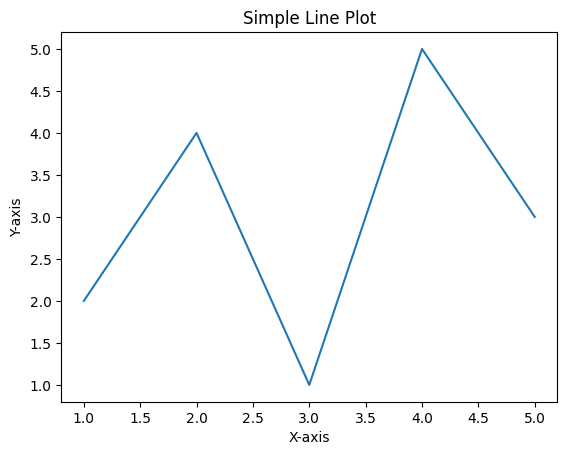

In [47]:


# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 5, 3]

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Display the plot
plt.show()

# GPT Model

# Retriever

In [57]:
# Load pre-trained GPT model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

# Tokenize and encode input data (example using the first answer in train_df)
inputs = tokenizer(train_df['answer'].iloc[0], return_tensors='pt')

# Forward pass through the model
outputs = model(**inputs)

# Extract embeddings (e.g., last hidden state)
embeddings = outputs.last_hidden_state


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [63]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'  # You can choose a different GPT-2 variant if needed
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def generate_text(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)  # Create attention mask

    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.7
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Generator

In [64]:

question_prompt = "Generate a question about: " + train_df['answer'].iloc[0]
generated_question = generate_text(question_prompt)
print("Generated Question:", generated_question)

# Assuming train_df['question'] contains lists and you want the first element of the first list
answer_prompt = "Generate an answer for: " + ' '.join(train_df['question'].iloc[0]) # Join list elements into a string
generated_answer = generate_text(answer_prompt)
print("Generated Answer:", generated_answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Question: Generate a question about: Paris, France, and the United States.

Answer:
...
 (1) The United Nations has a mandate to ensure that all countries that have ratified the Paris Agreement are able to participate in the
Generated Answer: Generate an answer for: What is the capital of Jacques anatole francois thibault?

The answer is: The capital is a capital.
...
 (1) The Capital of the French Revolution. The French


# Data Visualization


Scatter Plot

In [66]:


# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='GPT Embeddings for the First Token')

fig.show()


Line Plot


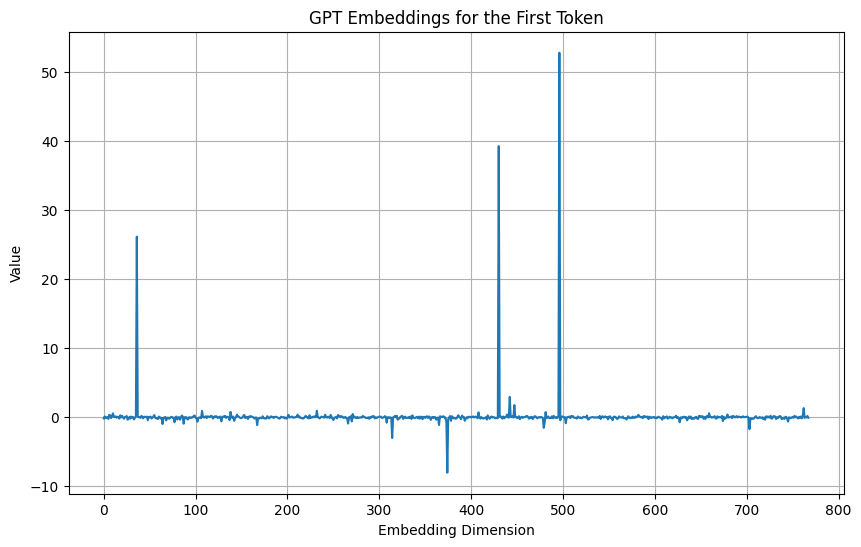

In [67]:


# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence across all dimensions
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(token_embeddings)
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.title('GPT Embeddings for the First Token')
plt.grid(True)
plt.show()


# **T5 Model**

In [74]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pre-trained T5 model and tokenizer
model_name = 't5-small'  # You can choose a different T5 variant if needed
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generator

In [77]:
# Define a function for generating text using T5
def generate_text_t5(prompt, max_length=50):
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)

    summary_ids = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )

    generated_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_text

Retriever

In [78]:
question_prompt = "Generate a question about: " + train_df['answer'].iloc[0]
generated_question = generate_text_t5(question_prompt)
print("Generated Question (T5):", generated_question)

answer_prompt = "Generate an answer for: " + ' '.join(train_df['question'].iloc[0])
generated_answer = generate_text_t5(answer_prompt)
print("Generated Answer (T5):", generated_answer)

Generated Question (T5): Generate a question about: Paris
Generated Answer (T5): Quelle est la capitale de Jacques anatole francois thibault?


# Data Visualization

Scatter Plot

In [85]:


# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='T5 Embeddings for the First Token')

fig.show()

Line Plot

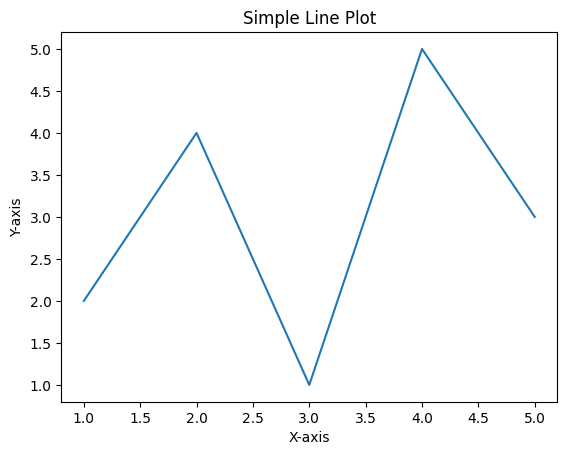

In [86]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 5, 3]

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Display the plot
plt.show()


In [90]:
# prompt: Implement train

from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,  # Replace with your chosen model
    args=training_args,
    train_dataset=train_dataset,  # Replace with your training dataset
    eval_dataset=test_dataset,  # Replace with your validation dataset
)

# Start training
trainer.train()


ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [question, answer]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [89]:
# prompt: # # generated_questions_gpt, generated_answers_gpt (for GPT model)
# # # generated_questions_t5, generated_answers_t5 (for T5 model)

# For GPT Model
generated_questions_gpt = []
generated_answers_gpt = []

for i in range(len(train_df)):
  question_prompt = "Generate a question about: " + train_df['answer'].iloc[i]
  generated_question = generate_text(question_prompt)
  generated_questions_gpt.append(generated_question)

  answer_prompt = "Generate an answer for: " + ' '.join(train_df['question'].iloc[i])
  generated_answer = generate_text(answer_prompt)
  generated_answers_gpt.append(generated_answer)

# For T5 Model
generated_questions_t5 = []
generated_answers_t5 = []

for i in range(len(train_df)):
  question_prompt = "Generate a question about: " + train_df['answer'].iloc[i]
  generated_question = generate_text_t5(question_prompt)
  generated_questions_t5.append(generated_question)

  answer_prompt = "Generate an answer for: " + ' '.join(train_df['question'].iloc[i])
  generated_answer = generate_text_t5(answer_prompt)
  generated_answers_t5.append(generated_answer)


In [88]:
# prompt: # Assuming you have generated questions and answers using your models and stored them in variables like:
# # generated_questions_gpt, generated_answers_gpt (for GPT model)
# # generated_questions_t5, generated_answers_t5 (for T5 model)

# Assuming you have generated questions and answers and stored them in variables:
# generated_questions_gpt, generated_answers_gpt (for GPT model)
# generated_questions_t5, generated_answers_t5 (for T5 model)

# Example usage (replace with your actual variables):
generated_questions_gpt = ["Generated question 1 from GPT", "Generated question 2 from GPT"]
generated_answers_gpt = ["Generated answer 1 from GPT", "Generated answer 2 from GPT"]
generated_questions_t5 = ["Generated question 1 from T5", "Generated question 2 from T5"]
generated_answers_t5 = ["Generated answer 1 from T5", "Generated answer 2 from T5"]

# Evaluate GPT-generated questions and answers using ROUGE
rouge_scores_gpt_questions = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores_gpt_answers = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i in range(len(generated_questions_gpt)):
    # Assuming you have reference questions and answers in val_df
    reference_question = val_df['question'].iloc[i]
    reference_answer = val_df['answer'].iloc[i]

    scores_question = rouge_scores_gpt_questions.score(reference_question, generated_questions_gpt[i])
    scores_answer = rouge_scores_gpt_answers.score(reference_answer, generated_answers_gpt[i])

    print(f"GPT - Question {i+1} ROUGE Scores:", scores_question)
    print(f"GPT - Answer {i+1} ROUGE Scores:", scores_answer)

# Evaluate T5-generated questions and answers using ROUGE
rouge_scores_t5_questions = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores_t5_answers = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i in range(len(generated_questions_t5)):
    # Assuming you have reference questions and answers in val_df
    reference_question = val_df['question'].iloc[i]
    reference_answer = val_df['answer'].iloc[i]

    scores_question = rouge_scores_t5_questions.score(reference_question, generated_questions_t5[i])
    scores_answer = rouge_scores_t5_answers.score(reference_answer, generated_answers_t5[i])

    print(f"T5 - Question {i+1} ROUGE Scores:", scores_question)
    print(f"T5 - Answer {i+1} ROUGE Scores:", scores_answer)


GPT - Question 1 ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
GPT - Answer 1 ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
GPT - Question 2 ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
GPT - Answer 2 ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
T5 - Question 1 ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, re